<a href="https://colab.research.google.com/github/RicoStaedeli/NLP2025_CQG/blob/main/5_Evaluation_Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import userdata
import os

In [2]:
token = userdata.get('GITHUB')
repo_url = f"https://{token}@github.com/RicoStaedeli/NLP2025_CQG.git"

!git clone {repo_url}


os.chdir("NLP2025_CQG")
!ls

Cloning into 'NLP2025_CQG'...
remote: Enumerating objects: 805, done.
remote: Counting objects: 100% (68/68), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 805 (delta 51), reused 37 (delta 36), pack-reused 737 (from 2)
Receiving objects: 100% (805/805), 25.38 MiB | 9.03 MiB/s, done.
Resolving deltas: 100% (403/403), done.
Updating files: 100% (86/86), done.
1_Information_preprocessing.md	      Development
1_Preprocessing.ipynb		      Doc
2_Baseline_Generation.ipynb	      Evaluation
2_Information_Baseline_Generation.md  INFORMATION.md
3a_Finetuned_CQS_generation.ipynb     LICENSE
3b_Finetune_Evaluation.ipynb	      Logs
3_Evaluation.ipynb		      README.md
4_Finetuned_Generation.ipynb	      requirements.txt
5_Evaluation_Analytics.ipynb	      Training
Data				      Utils


In [3]:
import json

result_file = "results_schema_Baseline_Meta-Llama-3.1-8B-Instruct-bnb-4bit"

with open(os.path.join(os.getcwd(), f"Evaluation/Scored/{result_file}_eval.json"), "r", encoding="utf-8") as f:
    data = json.load(f)

In [5]:
import pandas as pd

rows = []
for entry_id, entry_data in data.items():
    context = entry_data['input']
    for cq in entry_data['cqs']:
        row = {
            "id": entry_id,
            "input": context,
            "schema": cq["schema"],
            "question": cq["cq"],
            "CauseToEffect": cq["CauseToEffect"],
            "ExpertOpinion": cq["ExpertOpinion"],
            "Analogy": cq["Analogy"],
            "FearAppeal": cq["FearAppeal"],
            "is_critical": cq["is_critical"],
        }
        rows.append(row)

df = pd.DataFrame(rows)

df.head()

,id,input,schema,question,CauseToEffect,ExpertOpinion,Analogy,FearAppeal,is_critical
0,CLINTON_199_2,"CLINTON: ""which may prove to be an intelligenc...",CauseToEffect,Are there other factors in this particular cas...,3.0,0.0,3.5,3,False
1,CLINTON_199_2,"CLINTON: ""which may prove to be an intelligenc...",ExpertOpinion,Is Clinton's claim that working with NATO and ...,0.0,5.5,3.0,2,False
2,CLINTON_199_2,"CLINTON: ""which may prove to be an intelligenc...",Analogy,Are there differences between the approach of ...,0.0,6.0,7.0,2,True
3,CLINTON_199_2,"CLINTON: ""which may prove to be an intelligenc...",FearAppeal,Is it not a contradictory approach for Clinton...,2.0,3.0,4.0,2,False
4,CLINTON_1_2,"CLINTON: ""If you help create the profits , you...",CauseToEffect,Are there other factors in this particular cas...,3.0,2.0,3.5,3,False


In [10]:
df['schema_score'] = df.apply(lambda row: row[row['schema']], axis=1)

# 2. Group by schema to get total and critical counts
critical_summary = (
    df.groupby('schema')['is_critical']
    .agg(Total='count', Critical='sum')
    .reset_index()
)

# 3. Add accuracy as the proportion of critical questions
critical_summary['% Critical'] = (critical_summary['Critical'] / critical_summary['Total']) * 100

# 4. Compute schema score stats
score_stats = (
    df.groupby('schema')['schema_score']
    .agg(Average_Score='mean', Median_Score='median', Std_Dev='std', Min_Score='min', Max_Score='max')
    .reset_index()
)

# 5. Merge the two summaries
combined_summary = pd.merge(critical_summary, score_stats, on='schema')

# 6. Sort for readability
combined_summary = combined_summary.sort_values(by='Average_Score', ascending=False)

# Display
combined_summary

,schema,Total,Critical,% Critical,Average_Score,Median_Score,Std_Dev,Min_Score,Max_Score
0,Analogy,186,145,77.956989,7.395161,7.0,1.566034,3.0,10.0
2,ExpertOpinion,186,56,30.107527,5.053763,5.0,2.778258,0.0,10.5
3,FearAppeal,186,14,7.526882,3.768817,3.0,1.615899,2.0,8.0
1,CauseToEffect,186,16,8.602151,3.760753,3.0,2.477033,1.0,10.0


<ipython-input-11-017054efed9a>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='schema', y='schema_score', data=df, palette='Set2')


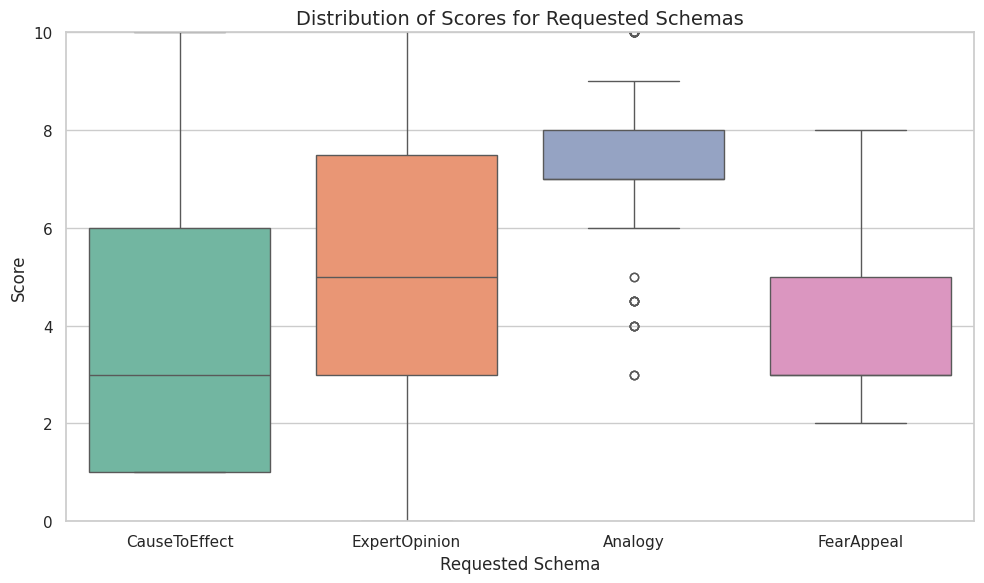

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Make sure schema_score is computed
df['schema_score'] = df.apply(lambda row: row[row['schema']], axis=1)

# Set visual style
sns.set(style="whitegrid")

# Create the boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='schema', y='schema_score', data=df, palette='Set2')

# Add titles and labels
plt.title('Distribution of Scores for Requested Schemas', fontsize=14)
plt.xlabel('Requested Schema')
plt.ylabel('Score')
plt.ylim(0, 10)
plt.tight_layout()
plt.show()

<ipython-input-12-7c1898fd55e1>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=score_counts.index.astype(int), y=score_counts.values, palette='viridis')


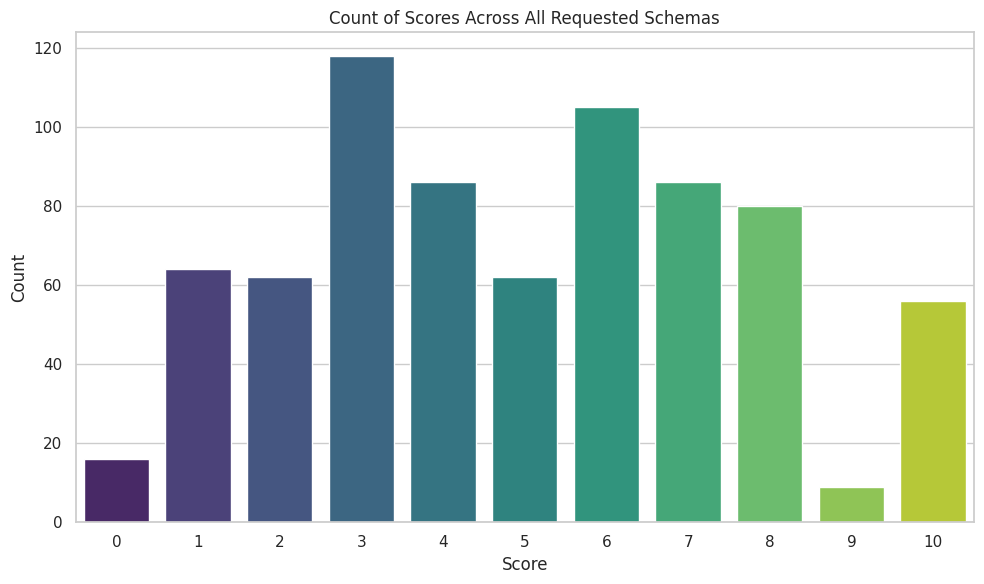

In [12]:
# If not already done: Create 'schema_score' column (score for the requested schema)
df['schema_score'] = df.apply(lambda row: row[row['schema']], axis=1)

# Count the occurrences of each score (round if needed, assuming integer scores)
score_counts = df['schema_score'].round().value_counts().sort_index()

# Plot the bar chart
plt.figure(figsize=(10,6))
sns.barplot(x=score_counts.index.astype(int), y=score_counts.values, palette='viridis')

plt.title('Count of Scores Across All Requested Schemas')
plt.xlabel('Score')
plt.ylabel('Count')
plt.xticks(score_counts.index.astype(int))
plt.tight_layout()
plt.show()

Count of questions per schema by is_critical:
is_critical    False  True 
schema                     
Analogy           41    145
CauseToEffect    170     16
ExpertOpinion    130     56
FearAppeal       172     14


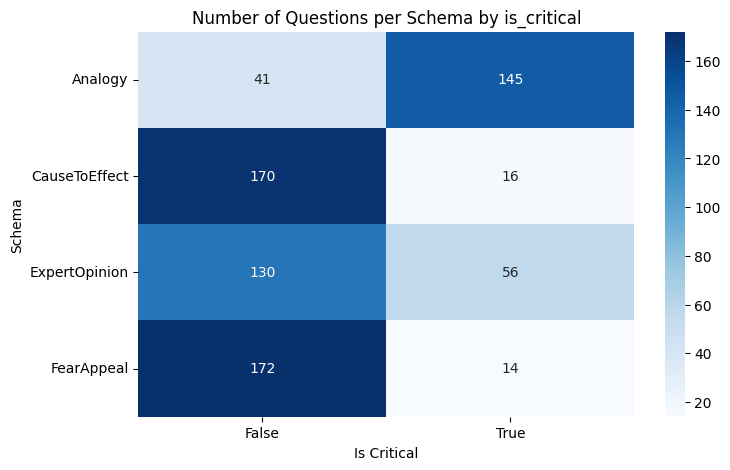

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

counts = pd.crosstab(df['schema'], df['is_critical'])

print("Count of questions per schema by is_critical:")
print(counts)

plt.figure(figsize=(8,5))
sns.heatmap(counts, annot=True, fmt='d', cmap='Blues')
plt.title('Number of Questions per Schema by is_critical')
plt.xlabel('Is Critical')
plt.ylabel('Schema')
plt.show()

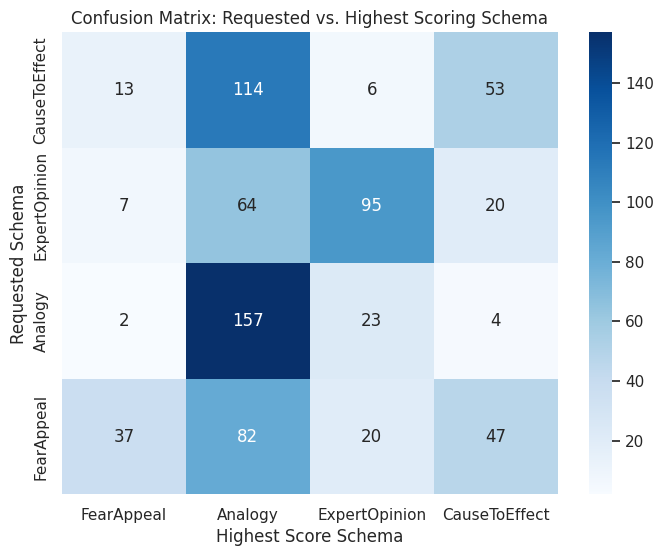

In [15]:
import numpy as np

# Original schema list
schemas = ['CauseToEffect', 'ExpertOpinion', 'Analogy', 'FearAppeal']

# Find predicted schema by highest score
df['predicted_schema'] = df[schemas].idxmax(axis=1)

# Compute confusion matrix with original label order
cm = confusion_matrix(df['schema'], df['predicted_schema'], labels=schemas)

# Reverse the predicted schema order (columns)
reversed_schemas = schemas[::-1]

# Reorder columns of confusion matrix
cm_reversed = cm[:, ::-1]

# Plot confusion matrix with reversed predicted schema order
plt.figure(figsize=(8,6))
sns.heatmap(cm_reversed, annot=True, fmt='d', cmap='Blues',
            xticklabels=reversed_schemas, yticklabels=schemas)

plt.xlabel('Highest Score Schema')
plt.ylabel('Requested Schema')
plt.title('Confusion Matrix: Requested vs. Highest Scoring Schema')
plt.show()
